In [58]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Lets first read the contents of the CSV File, to make sure everything is there

In [59]:
blockData = pd.read_csv("trust_chain_dataset_predictive.csv")
blockData

,Transaction ID,Timestamp,Item ID,Supplier ID,Customer ID,Location,Temperature,Humidity,GPS Coordinates,Order Amount,Quantity Shipped,Order Status,Payment Status,Time to Delivery,Quantity Mismatch,Fraud Indicator,Transaction Hash,Smart Contract Status,Compliance Check
0,TX00001,2025-02-05 13:58:29.739685,9102,S4,C9,Chicago,12.248374,67.459523,"(36.4275, -116.2052)",2996,153,Pending,Overdue,6,12,1,0xc11a,Active,0
1,TX00002,2025-02-04 13:58:29.739685,9435,S8,C6,Chicago,18.968854,41.879883,"(38.3798, -106.2317)",1182,76,Delivered,Paid,4,9,0,0x7b36,Completed,0
2,TX00003,2025-02-03 13:58:29.739685,9860,S6,C2,Chicago,15.050121,41.514624,"(41.5735, -93.3818)",1939,63,Pending,Overdue,5,2,1,0x15ce,Triggered,0
3,TX00004,2025-02-02 13:58:29.739685,9270,S3,C2,NY,17.310409,41.266084,"(36.2805, -96.2122)",2439,74,Shipped,Paid,6,1,0,0x8be6,Triggered,1
4,TX00005,2025-02-01 13:58:29.739685,9106,S4,C3,Chicago,6.741711,67.905965,"(38.316, -87.2957)",2915,101,Shipped,Paid,1,10,0,0x8a2d,Active,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,TX10344,1996-10-12 13:58:29.784898,9776,S5,C7,Chicago,5.247287,63.216954,"(37.7704, -92.7947)",2005,63,Delivered,Overdue,7,8,0,0x40dc,Active,1
10344,TX10345,1996-10-11 13:58:29.784898,9144,S6,C5,SF,6.117547,56.396645,"(37.8048, -106.6378)",1282,161,Delivered,Paid,2,4,0,0xf37a,Active,1
10345,TX10346,1996-10-10 13:58:29.784898,9068,S7,C4,LA,7.637715,42.554104,"(40.8892, -83.8448)",1592,183,Shipped,Paid,1,13,0,0xc4ac,Completed,0
10346,TX10347,1996-10-09 13:58:29.784898,9057,S2,C5,NY,6.707571,69.055645,"(37.1189, -114.84)",2677,168,Pending,Overdue,3,4,1,0xd665,Triggered,1


Here we proprocess and filter our data by only what we may need for Guassian Naive Bayes Algorithm. Not all features may be relevant or even helpful in our classification task particularly non numerical data. In this case we are choosing to encode non-numerical data so that we may use it in our Naive Bayes Classification.

In [60]:
columns_to_keep = ['Order Status', 'Payment Status', 'Quantity Mismatch', 'Time to Delivery', 'Order Amount', 'Quantity Shipped', 'Smart Contract Status', 'Compliance Check', 'Item ID', 'Supplier ID', 'Location', 'Fraud Indicator']
blockData_clean = blockData[columns_to_keep].copy()

blockData_clean

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,Pending,Overdue,12,6,2996,153,Active,0,9102,S4,Chicago,1
1,Delivered,Paid,9,4,1182,76,Completed,0,9435,S8,Chicago,0
2,Pending,Overdue,2,5,1939,63,Triggered,0,9860,S6,Chicago,1
3,Shipped,Paid,1,6,2439,74,Triggered,1,9270,S3,NY,0
4,Shipped,Paid,10,1,2915,101,Active,1,9106,S4,Chicago,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,Delivered,Overdue,8,7,2005,63,Active,1,9776,S5,Chicago,0
10344,Delivered,Paid,4,2,1282,161,Active,1,9144,S6,SF,0
10345,Shipped,Paid,13,1,1592,183,Completed,0,9068,S7,LA,0
10346,Pending,Overdue,4,3,2677,168,Triggered,1,9057,S2,NY,1


Encoding our non-numerical ordinal data, refrences: https://www.geeksforgeeks.org/machine-learning/ml-label-encoding-of-datasets-in-python/

In [61]:
numerate = LabelEncoder()
categorical_columns = ['Order Status', 'Payment Status', 'Smart Contract Status', 'Supplier ID', 'Location']

for col in categorical_columns:
    blockData_clean[col] = numerate.fit_transform(blockData_clean[col])

blockData_clean

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,1,0,12,6,2996,153,0,0,9102,4,0,1
1,0,1,9,4,1182,76,1,0,9435,8,0,0
2,1,0,2,5,1939,63,2,0,9860,6,0,1
3,2,1,1,6,2439,74,2,1,9270,3,2,0
4,2,1,10,1,2915,101,0,1,9106,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0,0,8,7,2005,63,0,1,9776,5,0,0
10344,0,1,4,2,1282,161,0,1,9144,6,3,0
10345,2,1,13,1,1592,183,1,0,9068,7,1,0
10346,1,0,4,3,2677,168,2,1,9057,2,2,1


In [62]:
blockData_randomized = blockData_clean.sample(frac=1, random_state=42)
blockData_randomized = blockData_randomized.reset_index(drop=True)
blockData_randomized

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location,Fraud Indicator
0,2,1,11,2,2352,183,0,0,9080,6,2,0
1,2,1,4,3,2426,122,0,1,9295,4,1,0
2,1,0,5,9,1718,182,0,0,9595,5,0,1
3,0,0,3,2,1318,130,0,0,9375,3,3,0
4,2,0,6,8,1618,78,0,0,9573,9,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0,0,5,5,2240,83,0,0,9435,4,3,0
10344,2,1,10,2,1920,125,0,1,9775,4,1,0
10345,2,1,13,1,2199,139,1,0,9014,3,3,0
10346,2,0,10,4,2664,151,0,1,9341,1,2,0


Here we seperate the outcomes from the classes

In [63]:
X = blockData_randomized.drop('Fraud Indicator', axis=1)
y = blockData_randomized['Fraud Indicator']

X.head()

,Order Status,Payment Status,Quantity Mismatch,Time to Delivery,Order Amount,Quantity Shipped,Smart Contract Status,Compliance Check,Item ID,Supplier ID,Location
0,2,1,11,2,2352,183,0,0,9080,6,2
1,2,1,4,3,2426,122,0,1,9295,4,1
2,1,0,5,9,1718,182,0,0,9595,5,0
3,0,0,3,2,1318,130,0,0,9375,3,3
4,2,0,6,8,1618,78,0,0,9573,9,2


Taking a look at our initial fraud labels

In [64]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Fraud Indicator, dtype: int64

We are spliting our data into training data and a test set here with an 80/20 split respectively

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, shuffle=True)
X_train.shape

(8278, 11)

## Naive Bayes Classification

Using a Gaussian Naive Bayes classification algorithm, which uses a normal distribution and calculates probabilities based on Bayes theorem. This algorithm works well where datasets features are independent of each other.

In [66]:
model = GaussianNB()
model.fit(X_train,y_train)
modelPrediction=model.predict(X_test)

modelPrediction

array([1, 0, 0, ..., 0, 0, 1], shape=(2070,))

Verifying our predictions against our test data

In [67]:
np.sum(y_test==modelPrediction) ## number of correct predictions

np.int64(1709)

# Accuracy Rate 

In [68]:
accuracy = np.sum(y_test==modelPrediction) / modelPrediction.size
accuracy

np.float64(0.8256038647342995)

# Random Forest 

Using a Random Forest classification model with 100 decision trees to improve prediction accuracy. Random Forest combines multiple decision trees to reduce overfitting and provide more robust predictions compared to a single decision tree algorithm. Refrencing https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html 

In [69]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_prediction = rf_model.predict(X_test)

rf_prediction

array([0, 0, 0, ..., 0, 0, 0], shape=(2070,))

Number of correct Random Forest predictions

In [70]:
np.sum(y_test == rf_prediction)

np.int64(1904)

Visualizing one decision tree, refrencing: https://www.geeksforgeeks.org/machine-learning/changing-colors-for-decision-tree-plot-using-sklearn-plot-tree/

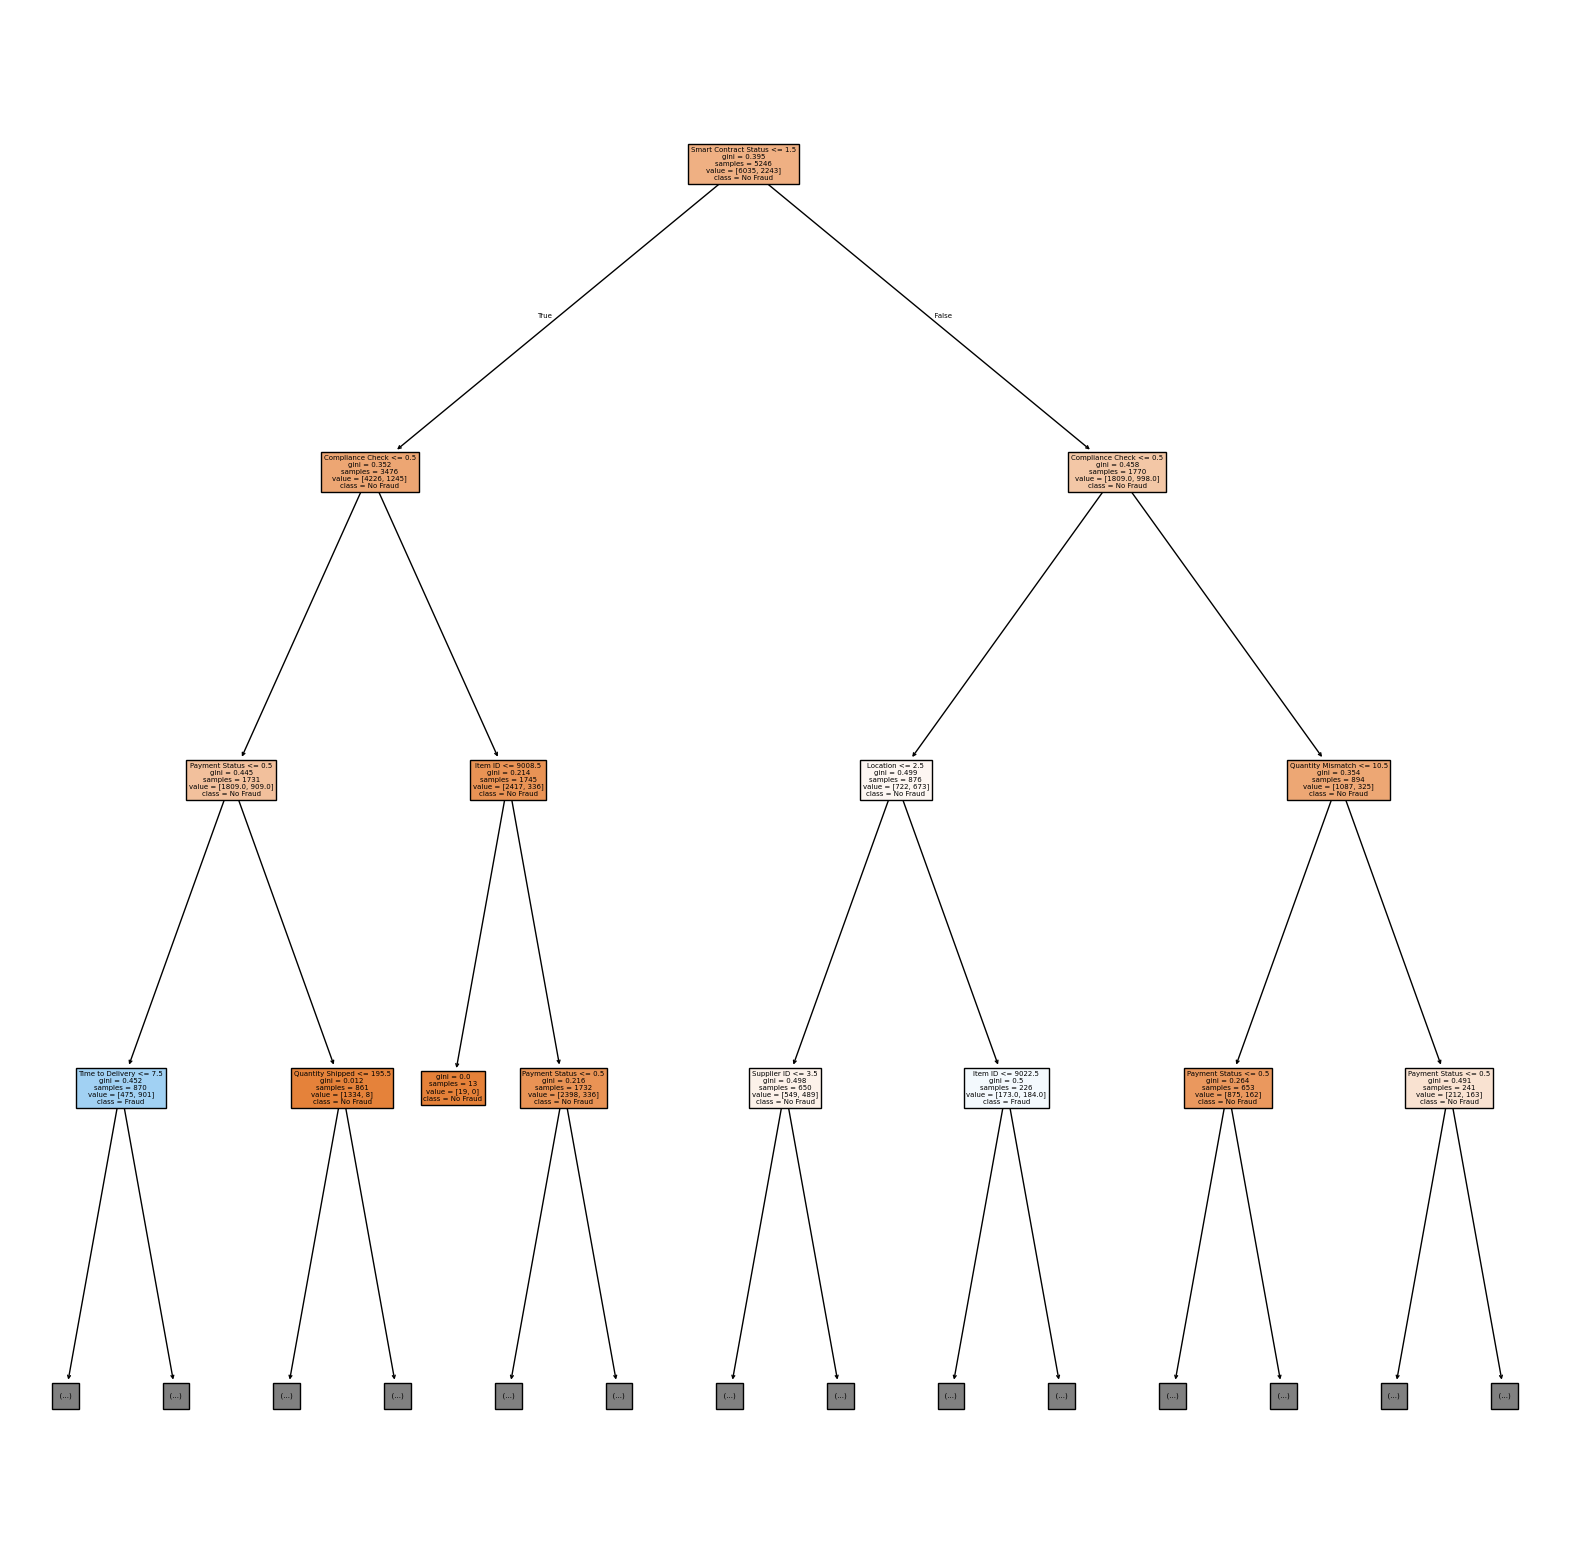

In [71]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, class_names=['No Fraud', 'Fraud'], filled=True, max_depth=3)
plt.show()

Accuracy Rate

In [72]:
rf_accuracy = np.sum(y_test == rf_prediction) / rf_prediction.size
rf_accuracy

np.float64(0.9198067632850242)

# Naive Bayes Vs. Random Forest

Comparing our findings we can see that Random Forest significantly outperforms Naive Bayes with accuracy rate of ~92% vs ~81.5% respectively. The Random Forest's approach of combining multiple decision trees provides better generalization and handles complex feature more effectively than the Naive Bayes algorithm.

In [73]:
# Compare both models
print("Naive Bayes Accuracy:", accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Naive Bayes Accuracy: 0.8256038647342995
Random Forest Accuracy: 0.9198067632850242


# XGBoost 

In [74]:
model = xgb.XGBClassifier(n_estimators=10)
model.fit(X_train,y_train)
XGmodelPrediction=model.predict(X_test)

XGmodelPrediction

array([0, 0, 0, ..., 0, 0, 0], shape=(2070,))

Evaluate the accuracy of the Model

In [75]:
accuracy = accuracy_score(y_test, XGmodelPrediction)
print('y_test:', y_test)
print('predictions:', XGmodelPrediction)
print(f"Accuracy: {accuracy * 100:.2f}%")


y_test: 5499     0
890      0
4488     0
10083    0
2351     0
        ..
2106     0
1720     0
9379     0
1566     0
9421     1
Name: Fraud Indicator, Length: 2070, dtype: int64
predictions: [0 0 0 ... 0 0 0]
Accuracy: 91.98%


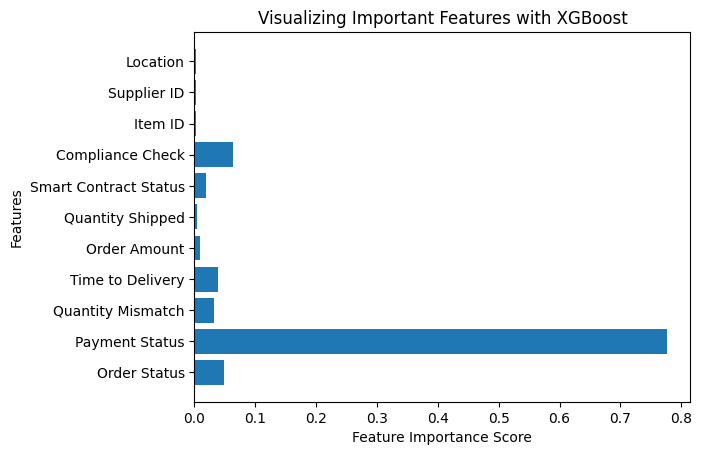

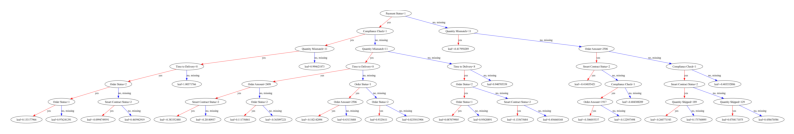

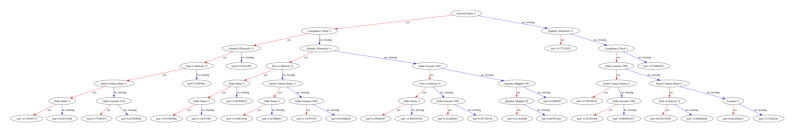

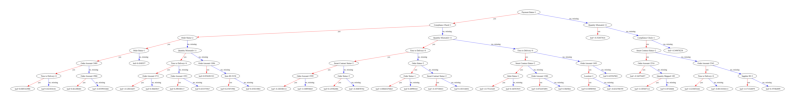

In [76]:
# Feature importance
feature_importance = model.feature_importances_

# Plotting feature importance
plt.barh(X.columns, feature_importance)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features with XGBoost')

# Plot the first 3 trees
for i in range(3):
  plt.figure(figsize = (10, 7))
  xgb.plot_tree(model, num_trees=i, ax=plt.gca())

plt.show()
